### 混合密度网络相关实验
包括如下几项：
1. MDN
2. RNN combines with MDN
3. MDN in uncertainty modeling

In [1]:
# import package
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F 
import torch.distributions as D
from torch.utils.data import DataLoader,Dataset

def params_count(model):
    """
    Compute the number of parameters.
    Args:
        model (model): model to count the number of parameters.
    """
    return np.sum([p.numel() for p in model.parameters()]).item()

In [2]:
# 实验配置
# 随机数种子
# seed = 0
# np.random.seed(seed)
# torch.manual_seed(seed)

In [3]:
# matplotlib绘图默认参数
mpl.rcParams['font.family'] = ['Times New Roman','SimSun'] 
mpl.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
mpl.rcParams['font.size'] = 9  # 按磅数设置的
mpl.rcParams['figure.dpi'] = 300
cm = 1/2.54  # centimeters in inches
mpl.rcParams['figure.figsize'] = (8*cm,6*cm)
mpl.rcParams['savefig.dpi'] = 900
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['axes.facecolor'] = 'white'

#### MDN Implement

In [4]:
# Baseline模型
class Baseline(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(Baseline,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.base = nn.Sequential(nn.Linear(self.input_size,self.hidden_size),# nn.BatchNorm1d(self.hidden_size),nn.Tanh(),
                                  nn.Tanh(),
                                  nn.Linear(self.hidden_size,self.hidden_size),# nn.BatchNorm1d(self.hidden_size),nn.Tanh(),
                                  nn.Tanh(),
                                  nn.Linear(self.hidden_size,self.output_size))
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-3)
        self.loss_func = nn.MSELoss()
        
    def forward(self,x):
        return self.base(x)
    
    @torch.no_grad()
    def predict(self,x):
        return self.base(x)


In [11]:
# Mixture Density Network模型
class MixtureDensityNetwork(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_componets):
        super(MixtureDensityNetwork,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size 
        self.output_size = output_size
        self.num_componets = num_componets
        
        self.block_1 = nn.Sequential(nn.Linear(self.input_size,self.hidden_size),nn.ReLU(),
                                     nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU())
        self.shortcut_1 = nn.Linear(self.input_size,self.hidden_size)
        self.block_2 = nn.Sequential(nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU(),
                                     nn.Linear(self.hidden_size,self.hidden_size),nn.ReLU())
        self.shortcut_2 = nn.Linear(self.hidden_size,self.hidden_size)
                                
        class CoefficientLayer(nn.Module):
            def __init__(self):
                super(CoefficientLayer,self).__init__()
            def forward(self,x):
                mode = 'softmax'
                if mode=='softmax':
                    return F.softmax(x,dim=-1)
                elif mode=='elu+1':
                    x = F.elu(x)+1.0
                    return x/x.sum(-1,keepdim=True)
                elif mode=='relu':
                    x = F.relu(x)
                    return x/(x.sum(-1,keepdim=True)+1e-4)
        
        self.c_layer = nn.Sequential(nn.Linear(self.hidden_size,self.num_componets),
                                     CoefficientLayer())
        
        # Gaussian
        self.mu_layer = nn.Linear(self.hidden_size,self.num_componets*self.output_size)
        
        class SigmaLayer(nn.Module):
            def __init__(self):
                super(SigmaLayer,self).__init__()
            def forward(self,x):
                mode = 'exp'
                if mode=='elu+1':
                    return F.elu(x)+1.0
                elif mode=='exp':
                    return torch.exp(x)
        
        self.sigma_layer = nn.Sequential(nn.Linear(self.hidden_size,self.num_componets*self.output_size),
                                         SigmaLayer())
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-3)
        
    def forward(self,x):
        x = self.block_1(x) + self.shortcut_1(x)
        x = self.block_2(x) + self.shortcut_2(x)
        c = self.c_layer(x)
        mu = self.mu_layer(x).reshape(-1,self.num_componets,self.output_size)
        sigma = self.sigma_layer(x).reshape(-1,self.num_componets,self.output_size)
        return c,mu,sigma
    
    def loss_func(self,y_pred,y):
        c,mu,sigma = y_pred
        # https://pytorch.org/docs/stable/generated/torch.diag_embed.html
        # https://pytorch.org/docs/stable/generated/torch.diagonal.html#torch.diagonal
        # components = D.MultivariateNormal(mu,torch.diag_embed(sigma))
        # c_log_prob = components.log_prob(y)
        # 直接计算快很多
        c_log_prob = - (self.output_size/2)*torch.log(torch.tensor(2*np.pi))[None,None,None] \
            - torch.log(sigma.prod(dim=-1,keepdim=True)) \
            + (-1/2*(y[:,None,:]-mu)**2*sigma**(-2))
        nll = -torch.logsumexp(c_log_prob+torch.log(c+1e-4)[:,:,None],dim=-1).mean()
        return nll
    
    @torch.no_grad()
    def predict(self,x):
        return self.forward(x)
    
    @torch.no_grad()
    def aleatoric_uncertainty(self,y_pred):
        # 计算并输出偶然不确定性
        c,_,sigma = y_pred
        # (batch_size,otuput_size)
        return (c[:,:,None]*sigma).sum(1)   
    
    @torch.no_grad()
    def epistemic_uncertainty(self,y_pred):
        # 计算并输出认知不确定性
        c,mu,_ = y_pred
        # (batch_size,otuput_size)
        return (c[:,:,None]*(mu-(c[:,:,None]*mu).sum(-2,keepdim=True))**2).sum(1)
    
    @torch.no_grad()
    def mean(self,y_pred):
        c,mu,_ = y_pred
        # (batch_size,output_size)
        return (c[:,:,None]*mu).sum(1)

    @torch.no_grad()
    def variance(self,y_pred):
        # (batch_size,output_size)
        return self.aleatoric_uncertainty(y_pred)+self.epistemic_uncertainty(y_pred)

In [6]:
# 模型相关组件
def train_step(model,x,y):
    y_pred = model(x)
    return model.loss_func(y_pred,y)

def train(model,train_dl,epoch_num):
    log = []  # 每个epoch中每一步的loss
    epoch_log = []  # 每个epoch的loss
    for epoch in range(1,epoch_num+1):
        # pbar = tqdm(total=len(train_dl),desc=f"Training ")
        log.append([])
        for x,y in train_dl:
            model.optimizer.zero_grad()
            loss = train_step(model,x,y)
            loss.backward()
            model.optimizer.step()
            log[-1].append(loss.item())
            # pbar.update(1)
        epoch_loss = np.array(log[-1]).sum()/len(train_dl)
        if epoch%100==0:  # 100个epoch输出一次
            print(f"epoch {epoch}: {epoch_loss}")
        epoch_log.append(epoch_loss)
    return epoch_log

class CustomDataset(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data
    def __getitem__(self,i):
        return self.x_data[i],self.y_data[i]
    def __len__(self):
        return self.x_data.shape[0]

#### 实验1

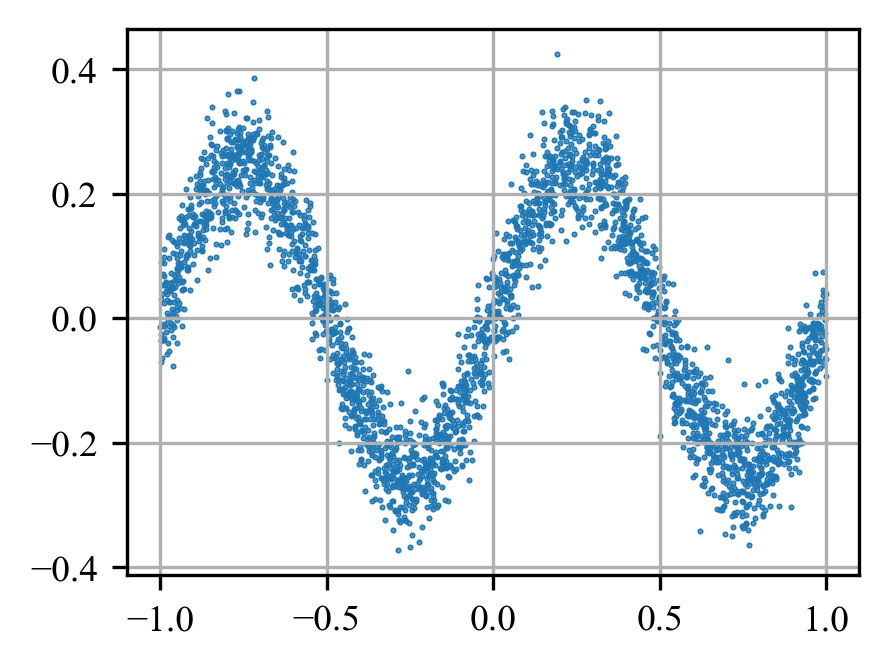

In [227]:
# 数据生成
num_samples = 3000
x = np.random.uniform(-1,1,size=(num_samples,1))
y1 = 0.25*np.sin(2*np.pi*x) + 0.05*np.random.normal(0,1,size=(num_samples,1))  # 加性噪声
y2 = x*np.random.uniform(0.95,1.05,size=(num_samples,1))-0.5  # 乘性噪声
y3 = 2*(np.random.choice(2,(num_samples,1))-0.5)*x**2 + np.random.normal(0,0.1,(num_samples,1))

fig,ax = plt.subplots()
ax.scatter(x,y1,s=0.2)


In [228]:
# 模型训练
y = y1
ds_1 = CustomDataset(torch.from_numpy(x).to(torch.float32),torch.from_numpy(y).to(torch.float32))
dl_1 = DataLoader(ds_1,batch_size=32,shuffle=True)

model = MixtureDensityNetwork(1,1)
# model = Baseline()
log = train(model,dl_1,3000)

epoch 100: -1.3586737526224015
epoch 200: -1.506178910427905
epoch 300: -1.5265002085807475
epoch 400: -1.5270568411400978
epoch 500: -1.5299516954320542
epoch 600: -1.5301586288086912
epoch 700: -1.5267147409155013
epoch 800: -1.5292311095176858
epoch 900: -1.5345759937103758
epoch 1000: -1.5429495890089806
epoch 1100: -1.5381840949362897
epoch 1200: -1.5365566446426067
epoch 1300: -1.5372777948988245
epoch 1400: -1.541573425556751
epoch 1500: -1.539624127935856
epoch 1600: -1.54172072765675
epoch 1700: -1.5387462796048914
epoch 1800: -1.5445791863380594
epoch 1900: -1.5440619638625612
epoch 2000: -1.5430918678324272
epoch 2100: -1.5377757612695084
epoch 2200: -1.5494345984560378
epoch 2300: -1.548738015458939
epoch 2400: -1.5470360631638385
epoch 2500: -1.5443701160714982
epoch 2600: -1.549334594543944
epoch 2700: -1.546820970291787
epoch 2800: -1.545793483866022
epoch 2900: -1.5534234604936965
epoch 3000: -1.5541286354369306


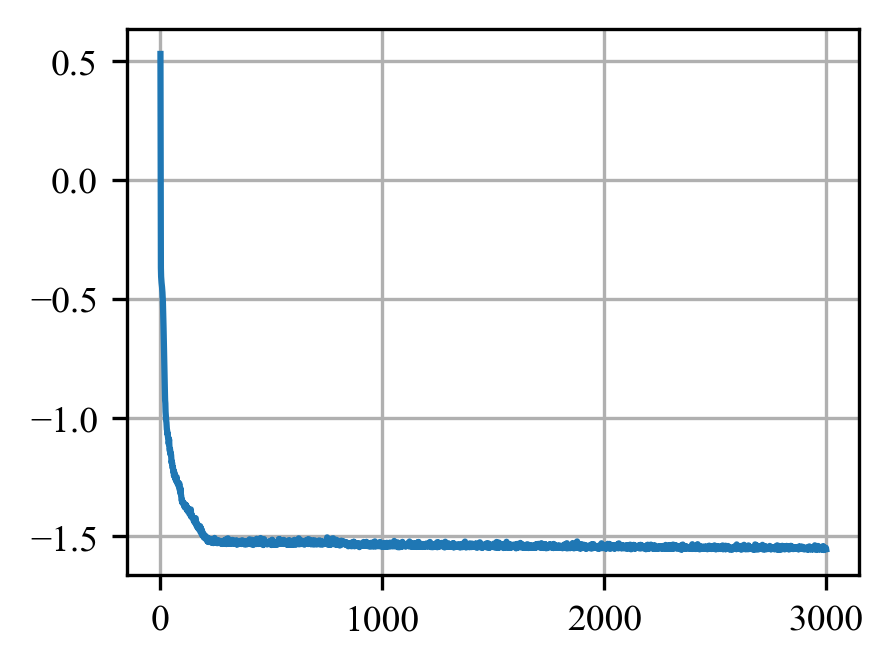

In [229]:
# 训练过程
plt.plot(np.array(log).reshape(-1))

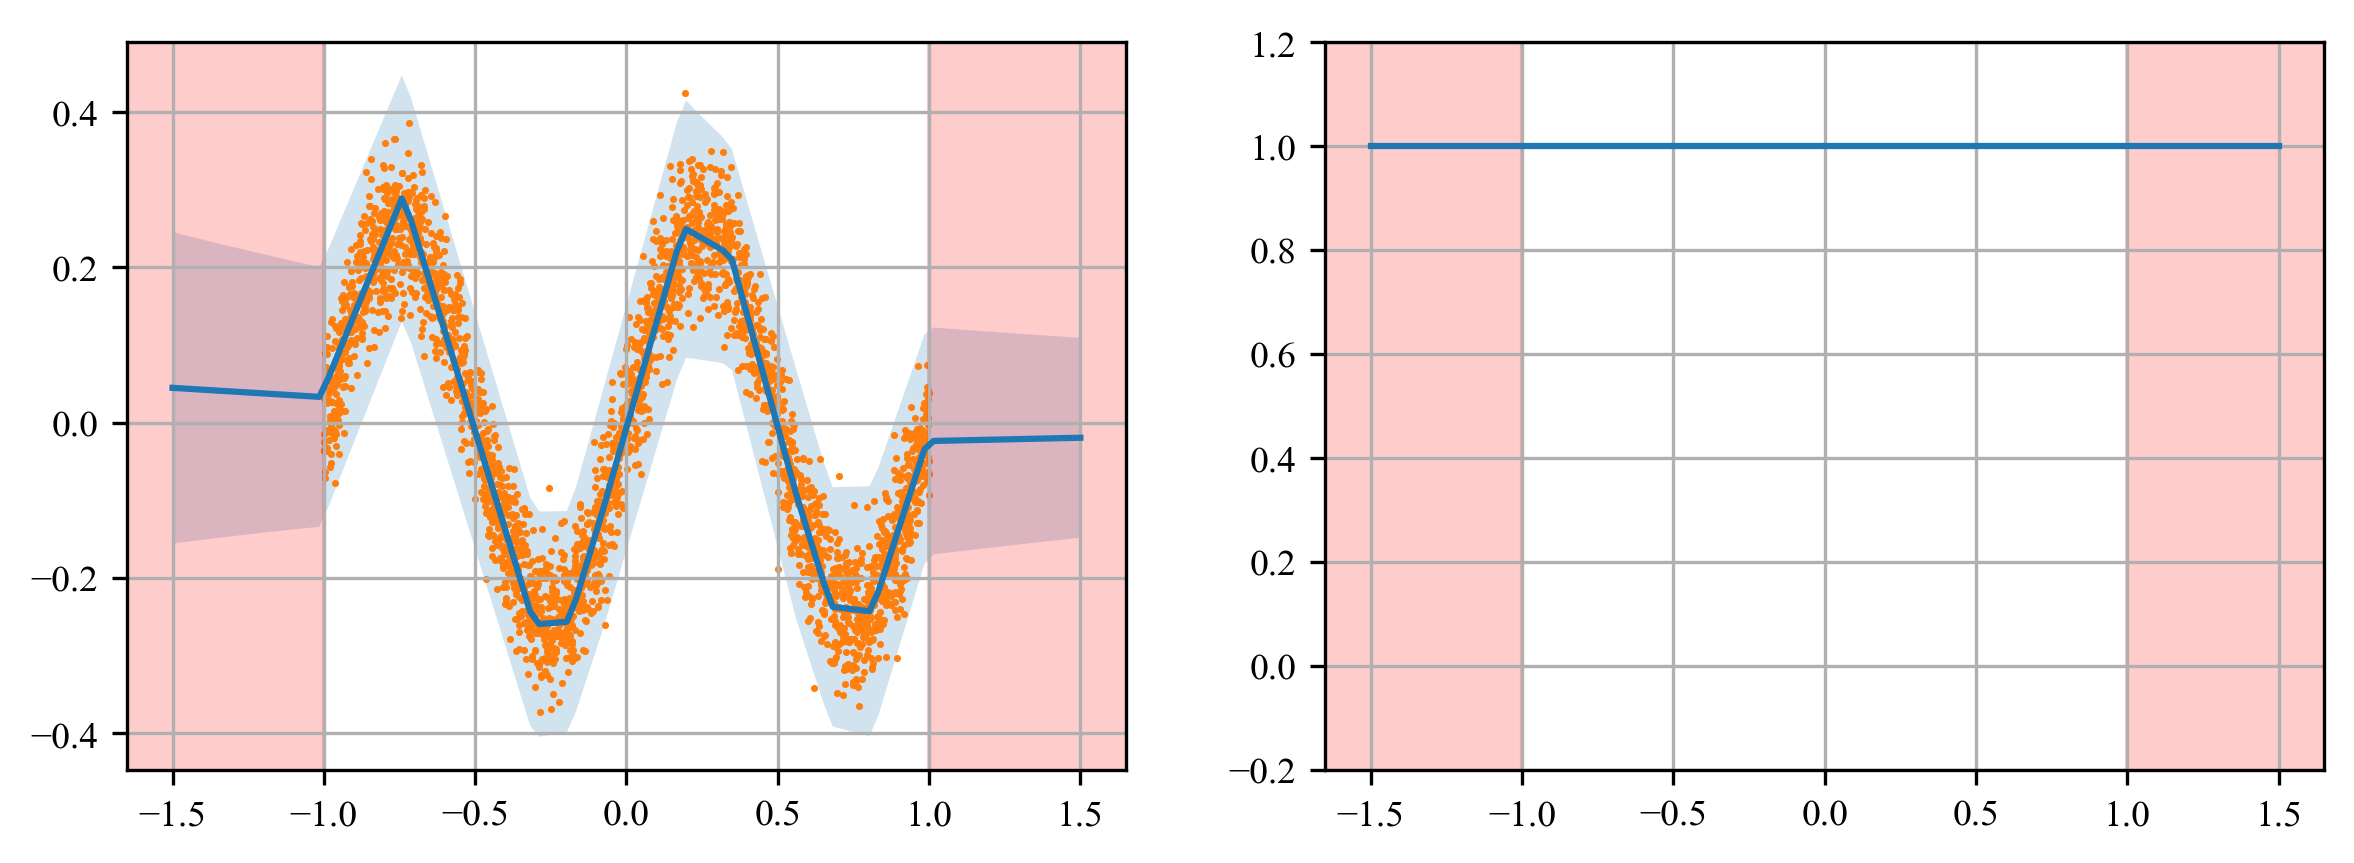

In [235]:
# 输出成分分析
fig,axes = plt.subplots(model.num_componets,2)
if model.num_componets==1:
    axes = axes[None,:]
    
x_space = np.linspace(-1.5,1.5,100)[:,None]
with torch.no_grad():
    for i in range(model.num_componets):
        c = model(torch.from_numpy(x_space).to(torch.float32))[0][:,[i]].numpy()
        mu = model(torch.from_numpy(x_space).to(torch.float32))[1][:,[i]].numpy()
        std = model(torch.from_numpy(x_space).to(torch.float32))[2][:,[i]].numpy()
        axes[i,0].plot(x_space,mu,label=f'componet {i+1}')
        axes[i,0].fill_between(x_space[:,0],(mu-3*std)[:,0],(mu+3*std)[:,0],alpha=0.2)
        axes[i,0].scatter(x,y,s=0.5,label='samples')
        
        axes[i,1].plot(x_space,c,label=f'componet {i+1}')
        axes[i,1].set_ylim([0.0,1.0])

fig.set_size_inches(24/2.54,model.num_componets*8/2.54)

#### 实验2

 ##### 实验数据生成
生成正弦函数的采样数据，体现数据噪声和数据失衡两种特征，分别对应偶然不确定性和认知不确定性。同时，还要探索潜在规律对认知不确定性的影响。

$x_1: x \in [0,3], y=sin(2 \pi x) + noise, noise \sim \mathcal{N} (0,0.1)$, 均匀随机采样1000个数据

$x_2: x \in [3,6], y=sin(2 \pi x)$, 均匀随机采样500个数据

$x_3: x \in [6,9], y=sin(2 \pi x) + noise, noise \sim \mathcal{N} (0,0.1)$, 均匀随机采样500个数据

$x_4: x \in [9,12], y=sin(2 \pi x)$, 均匀随机采样1000个数据

$x_5: x \in [12,15], y=sin(4 \pi x)$, 均匀随机采样1000个数据


In [7]:
# 数据生成
x1 = np.random.uniform(6,9,(1000,1))
x2 = np.random.uniform(3,6,(500,1))
x3 = np.random.uniform(12,15,(500,1))
x4 = np.random.uniform(9,12,(1000,1))
x5 = np.random.uniform(0,3,(1000,1))
x = np.concatenate([x1,x2,x3,x4,x5])

y1 = np.sin(0.5*np.pi*x1) + np.random.normal(0,0.1,(1000,1))
y2 = np.sin(0.5*np.pi*x2)
y3 = np.sin(0.5*np.pi*x3) + np.random.normal(0,0.1,(500,1))
y4 = np.sin(0.5*np.pi*x4)
y5 = np.sin(7/6*np.pi*x5)
y = np.concatenate([y1,y2,y3,y4,y5])


In [ ]:
# 数据可视化
fig,ax = plt.subplots()
ax.scatter(x1,y1,s=0.5)
ax.scatter(x2,y2,s=0.5)
ax.scatter(x3,y3,s=0.5)
ax.scatter(x4,y4,s=0.5)
ax.scatter(x5,y5,s=0.5)

fig.set_size_inches(14/2.54,6/2.54)

##### 模型训练

In [47]:
# BaseLine模型训练
ds = CustomDataset(torch.from_numpy(x).to(torch.float32),torch.from_numpy(y).to(torch.float32))
dl = DataLoader(ds,batch_size=64,shuffle=True)

model = Baseline(1,16,1)
print(params_count(model))
log = train(model,dl,1500)
torch.save(model.state_dict(),"./mdn_test_results/baseline.pth")

321
epoch 100: 0.42560258602339124
epoch 200: 0.3657898557564569
epoch 300: 0.30429099689400385
epoch 400: 0.24254509097053892
epoch 500: 0.12392187426014552
epoch 600: 0.020130818983214716
epoch 700: 0.004341861436380044
epoch 800: 0.004155792839204271
epoch 900: 0.004049468807698716
epoch 1000: 0.004396180289664439
epoch 1100: 0.0042533634382019205
epoch 1200: 0.004184184509092971
epoch 1300: 0.004314874901273657
epoch 1400: 0.004177981810200782
epoch 1500: 0.0041533577374167855


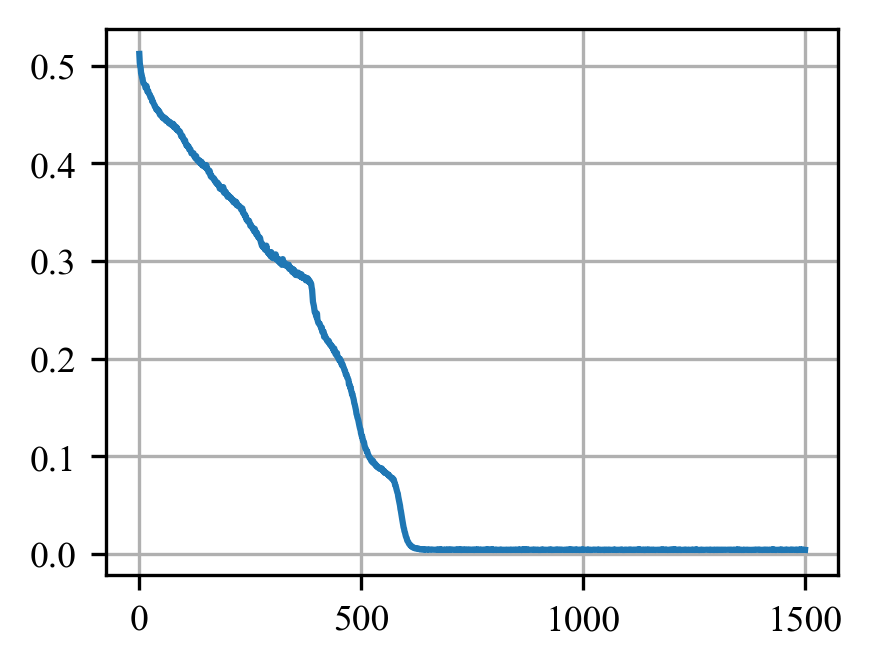

In [48]:
# Baseline训练过程
plt.plot(np.array(log).reshape(-1))

In [12]:
# MDN模型训练
ds = CustomDataset(torch.from_numpy(x).to(torch.float32),torch.from_numpy(y).to(torch.float32))
dl = DataLoader(ds,batch_size=256,shuffle=True)

model = MixtureDensityNetwork(1,32,1,10)
print(params_count(model))
log = train(model,dl,1500)
torch.save(model.state_dict(),"./mdn_test_results/mdn.pth")

5342
epoch 100: 2.8469194769859314
epoch 200: 3.010578081011772
epoch 300: 2.272598758339882
epoch 400: 1.961186833679676
epoch 500: 1.8047210946679115
epoch 600: 1.6867168620228767
epoch 700: 1.635667808353901
epoch 800: 1.9836402013897896
epoch 900: 1.7238303497433662
epoch 1000: 1.6913407891988754
epoch 1100: 1.4754194170236588
epoch 1200: 1.4227279499173164
epoch 1300: 1.4622798413038254
epoch 1400: 1.38413405418396
epoch 1500: 0.8810783922672272


(-5.0, 10.0)

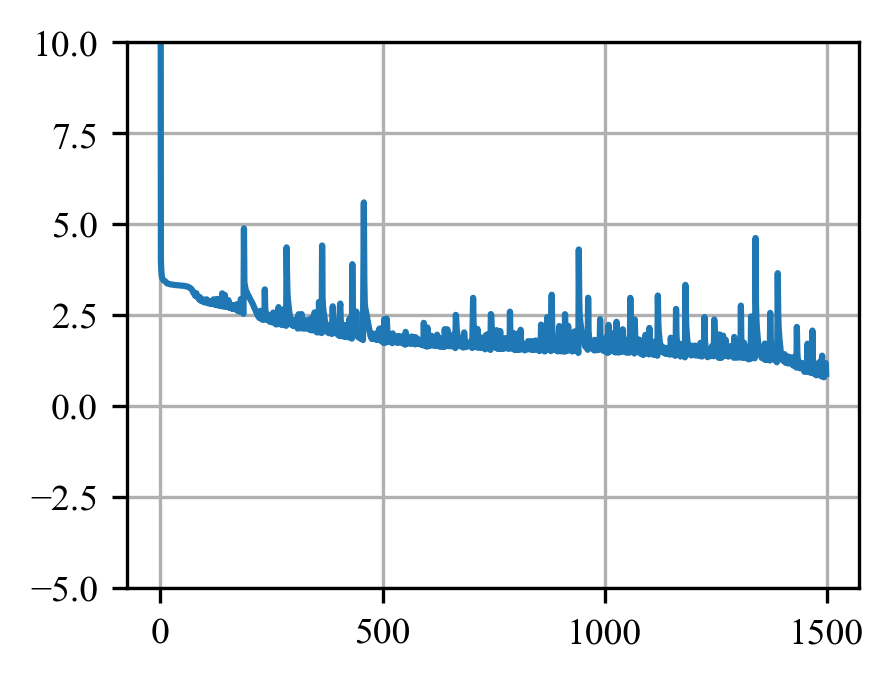

In [13]:
# MDN训练过程
plt.plot(np.array(log).reshape(-1))
plt.ylim([-5,10])

##### 可视化与分析

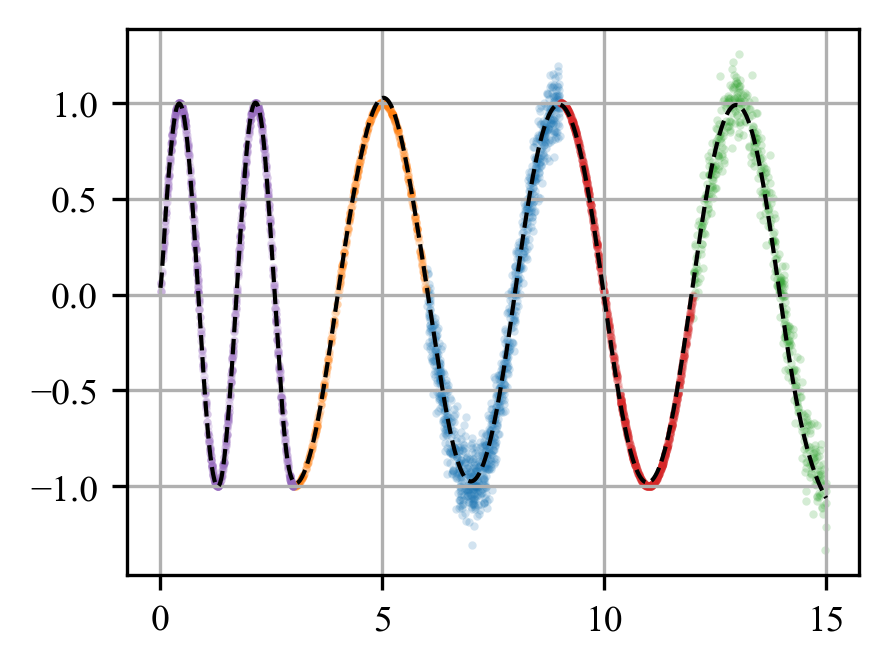

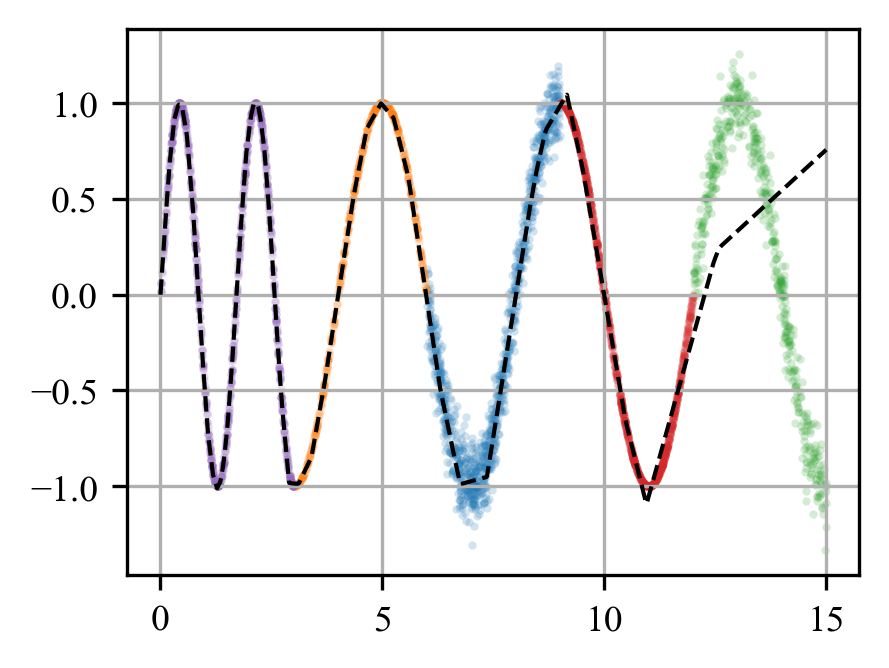

In [14]:
# 期望与方差
baseline = Baseline(1,16,1)
baseline.load_state_dict(torch.load("./mdn_test_results/baseline.pth"))
mdn = MixtureDensityNetwork(1,32,1,10)
mdn.load_state_dict(torch.load("./mdn_test_results/mdn.pth"))

fig,ax = plt.subplots()
ax.scatter(x1,y1,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x2,y2,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x3,y3,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x4,y4,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x5,y5,s=4.0,alpha=0.2,linewidths=0.0)

fig,ax = plt.subplots()
x_pred = torch.linspace(0.0,15.0,1000)[:,None]
y_pred = baseline.predict(x_pred)
ax.plot(x_pred,y_pred,linewidth=1.0,c='black',linestyle='--')
    
ax.scatter(x1,y1,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x2,y2,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x3,y3,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x4,y4,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x5,y5,s=4.0,alpha=0.2,linewidths=0.0)

fig,ax = plt.subplots()
x_pred = torch.linspace(0.0,15.0,1000)[:,None]
y_pred = mdn.predict(x_pred)
ax.plot(x_pred,mdn.mean(y_pred),linewidth=1.0,c='black',linestyle='--')

ax.scatter(x1,y1,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x2,y2,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x3,y3,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x4,y4,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x5,y5,s=4.0,alpha=0.2,linewidths=0.0)

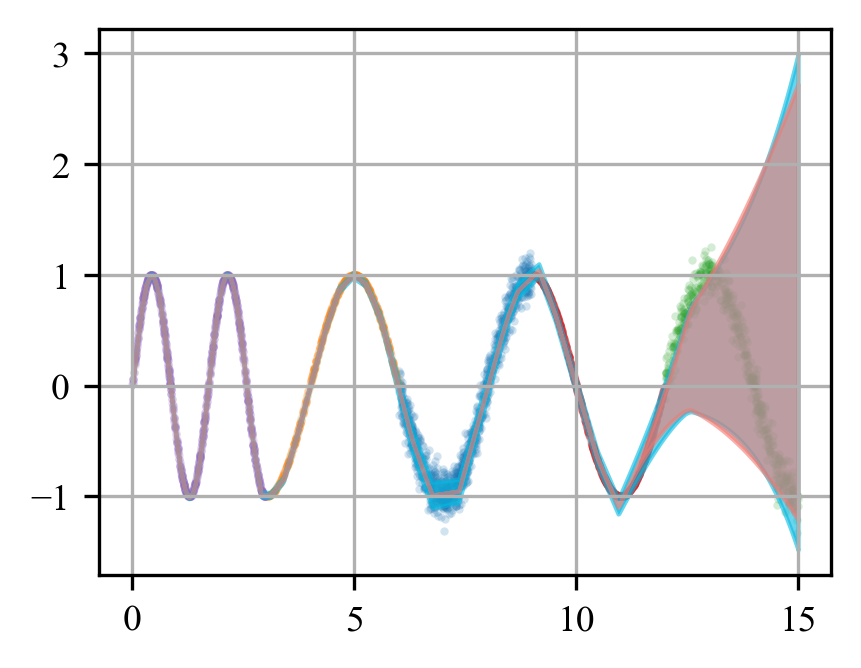

In [15]:
# 不确定性：定性
fig,ax = plt.subplots()
x_pred = torch.linspace(0.0,15.0,1000)[:,None]
y_pred = mdn.predict(x_pred)
mean = mdn.mean(y_pred)
au = mdn.aleatoric_uncertainty(y_pred)
eu = mdn.epistemic_uncertainty(y_pred)

ax.scatter(x1,y1,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x2,y2,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x3,y3,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x4,y4,s=4.0,alpha=0.2,linewidths=0.0)
ax.scatter(x5,y5,s=4.0,alpha=0.2,linewidths=0.0)

ax.fill_between(x_pred[:,0],
                (mean-au)[:,0],(mean+au)[:,0],
                color='#05B9E2',alpha=0.6)
ax.fill_between(x_pred[:,0],
                (mean-eu)[:,0],(mean+eu)[:,0],
                color='#F27970',alpha=0.6)

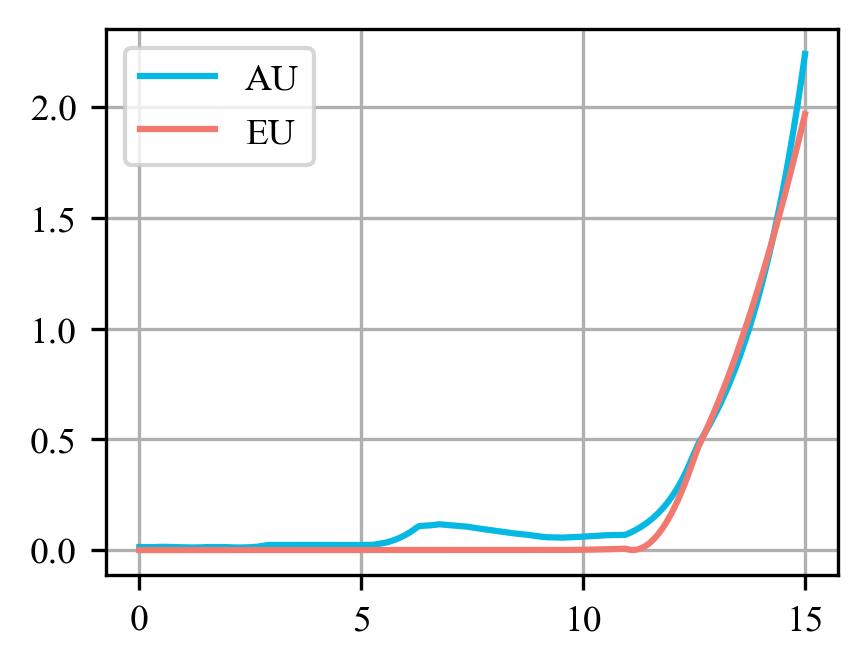

In [20]:
# 不确定性：定量
fig,ax = plt.subplots()
x_pred = torch.linspace(0.0,15.0,1000)[:,None]
y_pred = mdn.predict(x_pred)
mean = mdn.mean(y_pred)
au = mdn.aleatoric_uncertainty(y_pred)
eu = mdn.epistemic_uncertainty(y_pred)

ax.plot(x_pred,au,c='#05B9E2',label="AU")
ax.plot(x_pred,eu,c='#F27970',label="EU")

ax.legend()

In [ ]:
# 预测精度
